In [1]:
import copy
import pickle

import jax.nn
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpyro
import optax
import tqdm.notebook as tqdm
from numpyro import handlers

In [2]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import DataSlice, ToyData1, Sign
from experiments.src.model import BNNRegressor

In [3]:
# %matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,      # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,   # thick lines
    "lines.color": "k",     # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,     # higher resolution output.
})

In [4]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 3
VI_MAX_ITER = 100_000
BNN_SIZE = [32, 32]
BETA = 1.0
# FIG_PREFIX = f"fig"

## Data

In [42]:
data = ToyData1(D_X=D_X, train_size=100, sigma_obs=0.5)

In [43]:
binary_data = Sign(data)

## Model

In [45]:
bnn = BNNRegressor(
    nonlin=jax.nn.silu,
    D_X=D_X,
    D_Y=2,
    D_H=BNN_SIZE,
    biases=True,
    prior_scale=10,
    prior_type='xavier',
    obs_model="classification",
    # obs_model='loc_scale',
    # obs_model=1 / (0.05 / 0.26480442)**2,
    beta=BETA,
)


In [46]:
bnn.get_weight_dim()

1250

## Experiment

sample: 100%|██████████| 90/90 [00:22<00:00,  3.98it/s, 1023 steps of size 1.64e-02. acc. prob=0.64]



MCMC elapsed time: 25.93038296699524


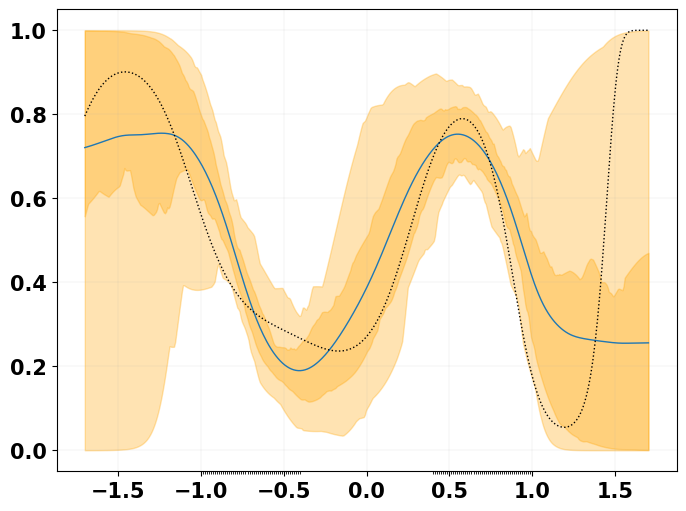

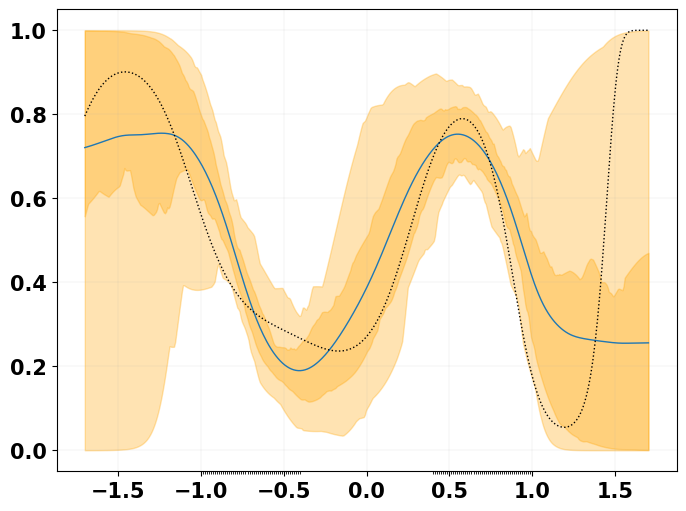

In [47]:
experiment = BasicHMCExperiment(
    bnn,
    binary_data,
    num_samples = 60, num_warmup = 30,
    # num_chains = 4, group_by_chain=True
)
experiment.run(random.PRNGKey(0))#.savefig("figs/simple_hmc_4.png")

In [48]:
experiment = AutoLaplaceExperiment(
    bnn,
    data,
    num_samples=10_000,
    max_iter=VI_MAX_ITER,
    diag=True,
    shrink=100.0,
)
rk = random.PRNGKey(0)
experiment.run(random.PRNGKey(1))
# experiment.show_convergence_plot()
# experiment.run(random.PRNGKey(1)).savefig("figs/simple_mfvi_4.png")
# experiment.show_convergence_plot().savefig("figs/simple_mfvi_conv_4.png")

TypeError: take_along_axis indices must be of integer type, got float32

In [ ]:
experiment = BasicMeanFieldGaussianVIExperiment(
    bnn, data, lr_schedule=optax.constant_schedule(-0.0005),
)

In [ ]:
for i in tqdm.tqdm(range(15)):
    rk, rkc = random.split(rk)
    experiment.train(rkc)
    with open("svi-state.pkl", "wb") as f:
        pickle.dump(experiment._saved_svi_state, f)
    rk, rkc = random.split(rk)
    experiment.make_predictions(rkc)
    experiment.make_plots().savefig(f"figs/post-pred-{i}.png")
    fig, ax = plt.subplots()
    ax.plot(-experiment._eval_losses[:, 1], label="-loglik")
    ax.plot(experiment._eval_losses[:, 2], label="+kl")
    # ax.set_ylim(experiment._eval_losses.min() - 10, jnp.percentile(experiment._eval_losses, 90.0))
    ax.legend()
    fig.savefig(f"figs/loss-{i}.png")

In [ ]:
# with open("/tmp/svi-state.pkl", "rb") as f:
#     print(pickle.load(f))

In [ ]:
# go again:
rk, rkc = random.split(rk)
experiment.train(rkc, num_iter=0)

In [ ]:
rk, rkc = random.split(rk)
experiment.make_predictions(rkc)
experiment.make_plots().show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(-experiment._eval_losses[:, 1], label="-loglik")
ax.plot(experiment._eval_losses[:, 2], label="+kl")
ax.legend()
fig.show()

## Space for running experiments

In [ ]:
fresh_bnn = copy.deepcopy(bnn)
fresh_data = copy.deepcopy(data)
first_half_data = DataSlice(fresh_data, slice(50))
second_half_data = DataSlice(fresh_data, slice(50,100))

In [ ]:
first_half_experiment = BasicMeanFieldGaussianVIExperiment(fresh_bnn, first_half_data, num_samples=1000, max_iter=VI_MAX_ITER)
# first_half_experiment.run(random.PRNGKey(0)).savefig("figs/manual_first_half_VI_4.png")
# first_half_experiment.show_convergence_plot().savefig("figs/manual_first_half_VI_conv_4.png")

In [ ]:
# rk = random.PRNGKey(0)
# # For consistency with exp
# rk, _ = random.split(rk)

In [ ]:
# first_half_experiment._data.train[0][..., 1].max()

In [ ]:
# rk, rkc = random.split(rk)
# first_half_experiment.train(rkc, num_iter=1_000)

In [ ]:
# rk, rkc = random.split(rk)
# first_half_experiment.make_predictions(rkc)
# first_half_experiment.make_plots().show()

In [ ]:
# plt.plot(first_half_experiment._losses[::(VI_MAX_ITER // 50)])
# plt.plot(first_half_experiment._eval_losses)

In [ ]:
# second_half_HMC_experiment = BasicHMCExperiment(fresh_bnn.with_prior(*first_half_experiment.posterior), second_half_data, num_samples=1000, num_warmup=500)
# second_half_HMC_experiment.run(random.PRNGKey(0)).savefig("figs/manual_second_half_HMC_4.png")

In [ ]:
# second_half_VI_experiment = BasicMeanFieldGaussianVIExperiment(fresh_bnn.with_prior(*first_half_experiment.posterior), second_half_data, num_samples=1000, max_iter=5*VI_MAX_ITER)
# second_half_VI_experiment.run(random.PRNGKey(0)).savefig("figs/manual_second_half_VI_4.png")

In [ ]:
sequential_experiment = SequentialExperiment(fresh_bnn, fresh_data, BasicMeanFieldGaussianVIExperiment, num_inference_steps=2, max_iter = VI_MAX_ITER)

In [ ]:
sequential_experiment = ExperimentWithLastBlockReplaced(sequential_experiment, BasicHMCExperiment, num_samples=200, num_warmup=100)

In [ ]:
# sequential_experiment.train(random.PRNGKey(0))

In [ ]:
# sequential_experiment.make_predictions(random.PRNGKey(2), final_only=False)

In [ ]:
# sequential_experiment.make_plots(final_only=False)

In [ ]:
# # Custom plotting for sequential experiment
# fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# for i, ax in enumerate(axs.ravel()):
#     experiment_block = sequential_experiment._sequential_experiment._experiment_blocks[i]
#     predictions = experiment_block._predictions["Y"][..., 0]
#     mean_predictions = experiment_block._predictions["Y_mean"][..., 0]
#     data = experiment_block._data
#     X, Y = data.train
#     X_test, _ = data.test
#     # compute mean prediction and confidence interval around median
#     mean_means = jnp.mean(mean_predictions, axis=0)
#     mean_percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
#     # plot training data
#     ax.plot(X[:, 1], Y[:, 0], "kx")
#     # plot predictions & quantiles
#     ax.plot(X_test[:, 1], mean_means, color="blue")
#     ax.fill_between(X_test[:, 1], *mean_percentiles, color="lightblue")
#     ax.set_title(str(data._train_idx_slice))
# fig.tight_layout()
# fig.savefig("figs/sequential-VI-simple3.png")

#### Draw samples from prior predictive

In [ ]:
fig, ax =  plt.subplots()
with handlers.seed(rng_seed=random.PRNGKey(1)):
    t = data.test[0]
    for _ in range(50):
        prior_fn = handlers.trace(fresh_bnn).get_trace(X=t, Y=None)["Y_mean"]["value"]
        ax.plot(t[:,1], prior_fn, alpha=0.5)
        # ax.set_yscale('log')
plt.savefig("figs/prior_pred.png")

#### Reverse dataset for two halves sequential experiment

In [ ]:
# fresh_bnn = copy.deepcopy(bnn)

In [ ]:
# reversed_data = ReverseData(data)

In [ ]:
# reversed_sequential_experiment = SequentialExperiment(fresh_bnn, reversed_data, BasicFullRankGaussianVIExperiment)

In [ ]:
# reversed_sequential_experiment.train(random.PRNGKey(0))

In [ ]:
# reversed_sequential_experiment.make_predictions(random.PRNGKey(1), final_only=False)

In [ ]:
# # Custom plotting for reversed sequential experiment
# fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# for i, ax in enumerate(axs.ravel()):
#     experiment_block = reversed_sequential_experiment._experiment_blocks[i]
#     predictions = experiment_block._predictions["Y"][..., 0]
#     data = experiment_block._data
#     X, Y = data.train
#     X_test, _ = data.test
#     # compute mean prediction and confidence interval around median
#     mean_predictions = jnp.mean(predictions, axis=0)
#     percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
#     # plot training data
#     ax.plot(X[:, 1], Y[:, 0], "kx")
#     # plot predictions & quantiles
#     ax.plot(X_test[:, 1], mean_predictions, color="blue")
#     ax.fill_between(X_test[:, 1], *percentiles, color="lightblue")
#     ax.set_title(str(data._train_idx_slice))
# fig.tight_layout()
# # fig.savefig("figs/sequential-full-rank-VI-reversed1.png")

#### Randomized dataset experiment

In [ ]:
# import numpy as np
# train_len = data.train[0].shape[0]
# random_perm = np.random.choice(np.arange(train_len), size=train_len, replace=False)
# permuted_data = PermutedData(data, random_perm)

In [ ]:
# plt.close('all')